*GPU of Colab is used for Better Speed*


In [4]:
import tensorflow as tf


In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import random
# from tensorflow.keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from  tensorflow.keras.layers import *
from  tensorflow.keras.activations import *
from  tensorflow.keras.models import *
from  tensorflow.keras.initializers import *
from  tensorflow.keras.utils import plot_model
from  tensorflow.keras.callbacks import *
from  tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from  tensorflow.keras.preprocessing import image



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
label_names = pd.read_csv("archive/chinese_mnist.csv")
label_names.head()

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九


In [22]:
id = label_names['sample_id']
labels = label_names['code']

###Preprocessing data

In [10]:
label_names.info

<bound method DataFrame.info of        suite_id  sample_id  code  value character
0             1          1    10      9         九
1             1         10    10      9         九
2             1          2    10      9         九
3             1          3    10      9         九
4             1          4    10      9         九
...         ...        ...   ...    ...       ...
14995        99          5     9      8         八
14996        99          6     9      8         八
14997        99          7     9      8         八
14998        99          8     9      8         八
14999        99          9     9      8         八

[15000 rows x 5 columns]>

In [16]:
import glob
# import pickle
import cv2
# import Image
filelist = glob.glob('archive/data/data/*.jpg')
print(len(filelist))
images = np.array([cv2.imread(fname) for fname in filelist])

# images = 
# train_labels = labels


#To see whether the range is correct
# print(max(train_images[1:500].flatten()))
# min(train_images[1:500].flatten())


15000


In [52]:
type(images)
len(images)
labels = [i.replace('archive/data/data/input','').replace('.jpg','').replace('_','_') for i in filelist]
print(labels[10])

_94_10_10


In [58]:
kk = []
for i in labels:
    if labels[-2] != '_':
        kk.append(i[-2]+i[-1])
    else:
        kk.append(i[-1]) 
print(kk[1],labels[1])
labels = kk

12 _76_2_12


In [67]:
images = images / 255.0

In [72]:
images.min()

0.0

In [73]:
images.shape

(15000, 64, 64, 3)

In [82]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# le.fit(list( labels))
# y = le.transform(list( labels))
y = pd.get_dummies(pd.DataFrame(labels))
# class_weights = compute_class_weight('balanced', np.unique(y),y )

# class_weights_dict = dict(zip(le.transform(list(le.classes_)), class_weights))


In [83]:
y

,0_10,0_11,0_12,0_13,0_14,0_15,0__1,0__2,0__3,0__4,0__5,0__6,0__7,0__8,0__9
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
14996,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
14997,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
14998,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [90]:
from sklearn.model_selection import train_test_split
X_train, X_test , y_train , y_test = train_test_split(images,y,test_size = 0.2,shuffle = True)

For example label '0' has come only 180 times, so it has to have more weight.

###Visualizing:

In [91]:
def show_images(images,width):
  fig=plt.figure(figsize=(8, 8))

  for i in range(1,len(images)):
      img = images[i-1]
      fig.add_subplot(width,width, i)
      plt.imshow(img)
  plt.show()
  

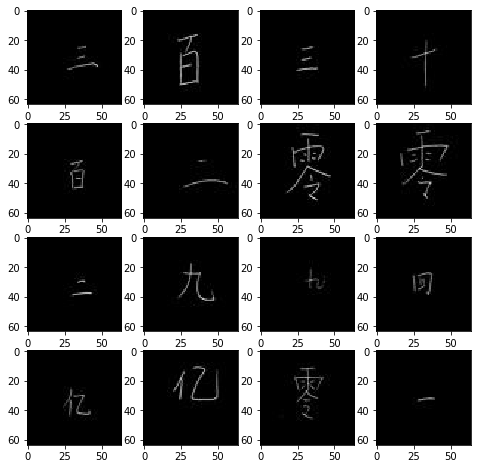

In [92]:
show_images(images[0:17],4)

So validation and train images needs to be shuffled:

Images are not equalized but Histogram Equalization only works on grayscale images. So we will use this method later.

Checking out train images again:

In [96]:
datagen = ImageDataGenerator(
        validation_split = 0.2,
        featurewise_center=False,  
        samplewise_center=False,
        featurewise_std_normalization=False,  
        brightness_range=None, 
        samplewise_std_normalization=False, 
        zca_whitening=False,  
        # rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 10)
        zoom_range = random.uniform(-0.1,0.1) , # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  

#Creating Model

In below a function is defined to make the visualization of each result easier and make code more organaized.

In [98]:
def eval_visual_model(models, batch_sizes, epoch, draw_plot = False,early_stopping = False):

    train_gen = datagen.flow(X_train,
                                y=y_train,
                                batch_size = batch_sizes)

    valid_gen = datagen.flow(X_test,
                                y=y_test,
                                batch_size = batch_sizes)

    for model in models:

      eses = []
      if early_stopping:
        es1 = EarlyStopping(monitor='accuracy', verbose=1,mode = 'max', patience=10)
        es2 = EarlyStopping(monitor='val_loss', verbose=1, patience=10,mode = 'min' ) #when validation loss starts to increase means we start overfitting so it stops after 10 epochs
        eses = [es1,es2]

      Model = model.fit(train_gen, 
                    shuffle=True,
                    # class_weight = class_weights_dict,
                    epochs=epoch, 
                    verbose = 1,
                    callbacks = eses,
                    validation_data = valid_gen,
                    steps_per_epoch=X_train.shape[0]//batch_sizes,
                    # validation_steps= y_train.shape[0] // batch_sizes)

      print('\n\nResult on Test Set:')
      t = model.evaluate(X_test, y_test)
      # print('\nResult on Validation Set:')
      # v = model.evaluate(X__test, y_test)

      if draw_plot :
        plt.plot(Model.history['loss'])
        plt.plot(Model.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['loss', 'val_loss'], loc='upper right')
        plt.show()
      return Model


In [107]:
y_train.shape

(12000, 15)

In [110]:
model_0 = Sequential()

model_0.add(Conv2D(64, kernel_size=(8, 8), activation='relu',  input_shape=(64, 64, 3)))
model_0.add(Conv2D(64, (6, 6), activation='relu',  input_shape=(64, 64, 3)))
model_0.add(MaxPooling2D(pool_size=(2, 2)))
model_0.add(BatchNormalization(axis = -1))

model_0.add(Dropout(0.1))

model_0.add(Conv2D(64, (3, 3), activation='relu',  input_shape=(64, 64, 3)))
model_0.add(MaxPooling2D(pool_size=(2, 2)))
model_0.add(BatchNormalization(axis = -1))

model_0.add(Flatten())

model_0.add(Dense(128, activation='relu'))
model_0.add(Dropout(0.1))
model_0.add(Dense(15, activation='softmax'))

model_0.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [111]:
eval_visual_model([model_0], batch_sizes = 20, epoch = 10)

Epoch 1/10
600/600 [==============================] - 482s 804ms/step - loss: 1.2334 - accuracy: 0.6082 - val_loss: 1.8913 - val_accuracy: 0.5420
Epoch 2/10
600/600 [==============================] - 428s 713ms/step - loss: 0.3326 - accuracy: 0.8949
Epoch 3/10
600/600 [==============================] - 424s 706ms/step - loss: 0.2112 - accuracy: 0.9339
Epoch 4/10
305/600 [==============>...............] - ETA: 3:23 - loss: 0.1882 - accuracy: 0.9480

KeyboardInterrupt: 

5 more epochs:

The speed is so low. we need more rich network.

Change optimizer to adam:

In [223]:
model_1 = Sequential()

model_1.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)))
model_1.add(BatchNormalization(axis = 1))
model_1.add(MaxPool2D(pool_size=2))

model_1.add(Flatten())

model_1.add(Dense(50, activation='relu'))
model_1.add(Dense(43, activation='sigmoid'))

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/10
1739/1739 [==============================] - 22s 13ms/step - loss: 3.0367 - accuracy: 0.0974 - val_loss: 2.5745 - val_accuracy: 0.1936
Epoch 2/10
1739/1739 [==============================] - 22s 13ms/step - loss: 2.1800 - accuracy: 0.2623 - val_loss: 2.2400 - val_accuracy: 0.2407
Epoch 3/10
1739/1739 [==============================] - 22s 13ms/step - loss: 1.8931 - accuracy: 0.3446 - val_loss: 2.0945 - val_accuracy: 0.3095
Epoch 4/10
1739/1739 [==============================] - 22s 13ms/step - loss: 1.6361 - accuracy: 0.4189 - val_loss: 2.1632 - val_accuracy: 0.3466
Epoch 5/10
1739/1739 [==============================] - 22s 13ms/step - loss: 1.4447 - accuracy: 0.4671 - val_loss: 2.0904 - val_accuracy: 0.3730
Epoch 6/10
1739/1739 [==============================] - 22s 13ms/step - loss: 1.3306 - accuracy: 0.5026 - val_loss: 2.1011 - val_accuracy: 0.3982
Epoch 7/10
1739/1739 [==============================] - 22s 13ms/step - loss: 1.2095 - accuracy: 0.5449 - val_loss: 2.0045 -

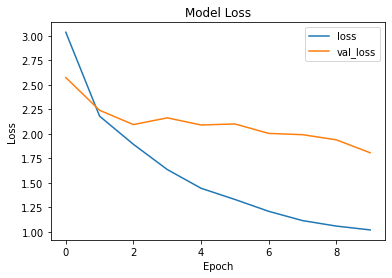

In [224]:
eval_visual_model([model_1],batch_sizes =  20, epoch = 10 , draw_plot=True)

The Network is too weak. 



Let's create more rich network.

In [53]:
model_2 = Sequential()

model_2.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)))
model_2.add(BatchNormalization(axis = 1) )
model_2.add(MaxPool2D(pool_size=2))

model_2.add(Dropout(0.1))

model_2.add(Conv2D(64, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)))
model_2.add(BatchNormalization(axis = 1) )
model_2.add(MaxPool2D(pool_size=2))

model_2.add(Dropout(0.2))
model_2.add(Conv2D(53, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
model_2.add(BatchNormalization(axis = 1) )
model_2.add(MaxPool2D(pool_size=2))

model_2.add(Flatten())

model_2.add(Dense(64, activation='relu'))
model_2.add(Dropout(0.05))

model_2.add(Dense(43, activation='softmax'))
sgd = SGD(0.16,0.9)


model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/250
69/69 [==============================] - 17s 243ms/step - loss: 3.7228 - accuracy: 0.0440 - val_loss: 3.7744 - val_accuracy: 0.0483
Epoch 2/250
69/69 [==============================] - 16s 239ms/step - loss: 3.3115 - accuracy: 0.0818 - val_loss: 4.1108 - val_accuracy: 0.0373
Epoch 3/250
69/69 [==============================] - 17s 240ms/step - loss: 2.6237 - accuracy: 0.1988 - val_loss: 4.3990 - val_accuracy: 0.0327
Epoch 4/250
69/69 [==============================] - 16s 239ms/step - loss: 1.8755 - accuracy: 0.3933 - val_loss: 4.2064 - val_accuracy: 0.0573
Epoch 5/250
69/69 [==============================] - 16s 238ms/step - loss: 1.3221 - accuracy: 0.5350 - val_loss: 3.5437 - val_accuracy: 0.0890
Epoch 6/250
69/69 [==============================] - 16s 238ms/step - loss: 0.9736 - accuracy: 0.6269 - val_loss: 3.0356 - val_accuracy: 0.1815
Epoch 7/250
69/69 [==============================] - 17s 240ms/step - loss: 0.7951 - accuracy: 0.6838 - val_loss: 1.9260 - val_accuracy:

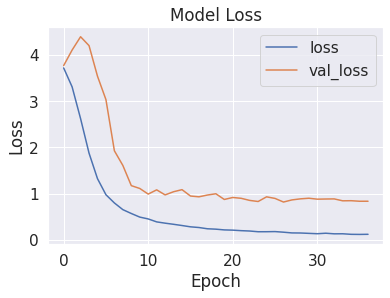

In [54]:
eval_visual_model([model_2],batch_sizes =  500, epoch = 250,draw_plot=True, early_stopping=True)

Trying another network



In [228]:
model_3 = Sequential()

model_3.add(Conv2D(32, kernel_size=12, padding='same', activation='relu', input_shape=(32, 32, 3)))
model_3.add(MaxPool2D(pool_size=2))

model_3.add(Dropout(0.2))

model_3.add(Conv2D(64, kernel_size=9, padding='same', activation='relu', input_shape=(32, 32, 3)))
model_3.add(Dense(16, activation='relu'))
model_3.add(BatchNormalization() )

model_3.add(Dropout(0.1))


model_3.add(Conv2D(128, kernel_size=6, padding='same', activation='relu', input_shape=(32, 32, 3)))
model_3.add(AveragePooling2D( pool_size=2, strides=2, padding="same"))
model_3.add(BatchNormalization() )

model_3.add(Dropout(0.2))


model_3.add(Conv2D(180, kernel_size=9, padding='same', activation='relu', input_shape=(32, 32, 3)))
model_3.add(MaxPool2D(pool_size=2))
model_3.add(BatchNormalization( ) )

model_3.add(Dropout(0.4))

model_3.add(Conv2D(2000, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)))
model_3.add(MaxPool2D(pool_size=2))
model_3.add(BatchNormalization( ) )

model_3.add(Dropout(0.3))

model_3.add(Flatten())

model_3.add(Dense(128, activation='relu'))
model_3.add(BatchNormalization( ) )
model_3.add(Dropout(0.4))
model_3.add(Dense(20, activation='relu'))

model_3.add(Dense(43, activation='softmax'))
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/500
289/289 [==============================] - 21s 72ms/step - loss: 3.7225 - accuracy: 0.0324 - val_loss: 3.7581 - val_accuracy: 0.0380
Epoch 2/500
289/289 [==============================] - 20s 70ms/step - loss: 3.2651 - accuracy: 0.0763 - val_loss: 3.2509 - val_accuracy: 0.1248
Epoch 3/500
289/289 [==============================] - 20s 69ms/step - loss: 2.3753 - accuracy: 0.2307 - val_loss: 2.4481 - val_accuracy: 0.2553
Epoch 4/500
289/289 [==============================] - 20s 71ms/step - loss: 1.6864 - accuracy: 0.4081 - val_loss: 1.6826 - val_accuracy: 0.4664
Epoch 5/500
289/289 [==============================] - 21s 72ms/step - loss: 1.1735 - accuracy: 0.5623 - val_loss: 1.2880 - val_accuracy: 0.5903
Epoch 6/500
289/289 [==============================] - 20s 71ms/step - loss: 0.8822 - accuracy: 0.6592 - val_loss: 1.2617 - val_accuracy: 0.6023
Epoch 7/500
289/289 [==============================] - 20s 71ms/step - loss: 0.6906 - accuracy: 0.7271 - val_loss: 0.9164 - val_ac

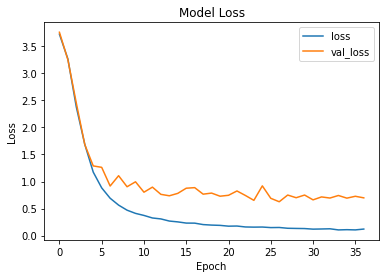

In [229]:
eval_visual_model([model_3],batch_sizes =  120, epoch = 500,draw_plot=True,early_stopping=True)

From here, It starts to be overfitted.

###Visualize Best Mode Up to Here

In [230]:
model_3.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_117 (Conv2D)          (None, 32, 32, 32)        13856     
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_96 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 16, 16, 64)        165952    
_________________________________________________________________
dense_82 (Dense)             (None, 16, 16, 16)        1040      
_________________________________________________________________
batch_normalization_69 (Batc (None, 16, 16, 16)        64        
_________________________________________________________________
dropout_97 (Dropout)         (None, 16, 16, 16)      

**Taking a look at feature map:**

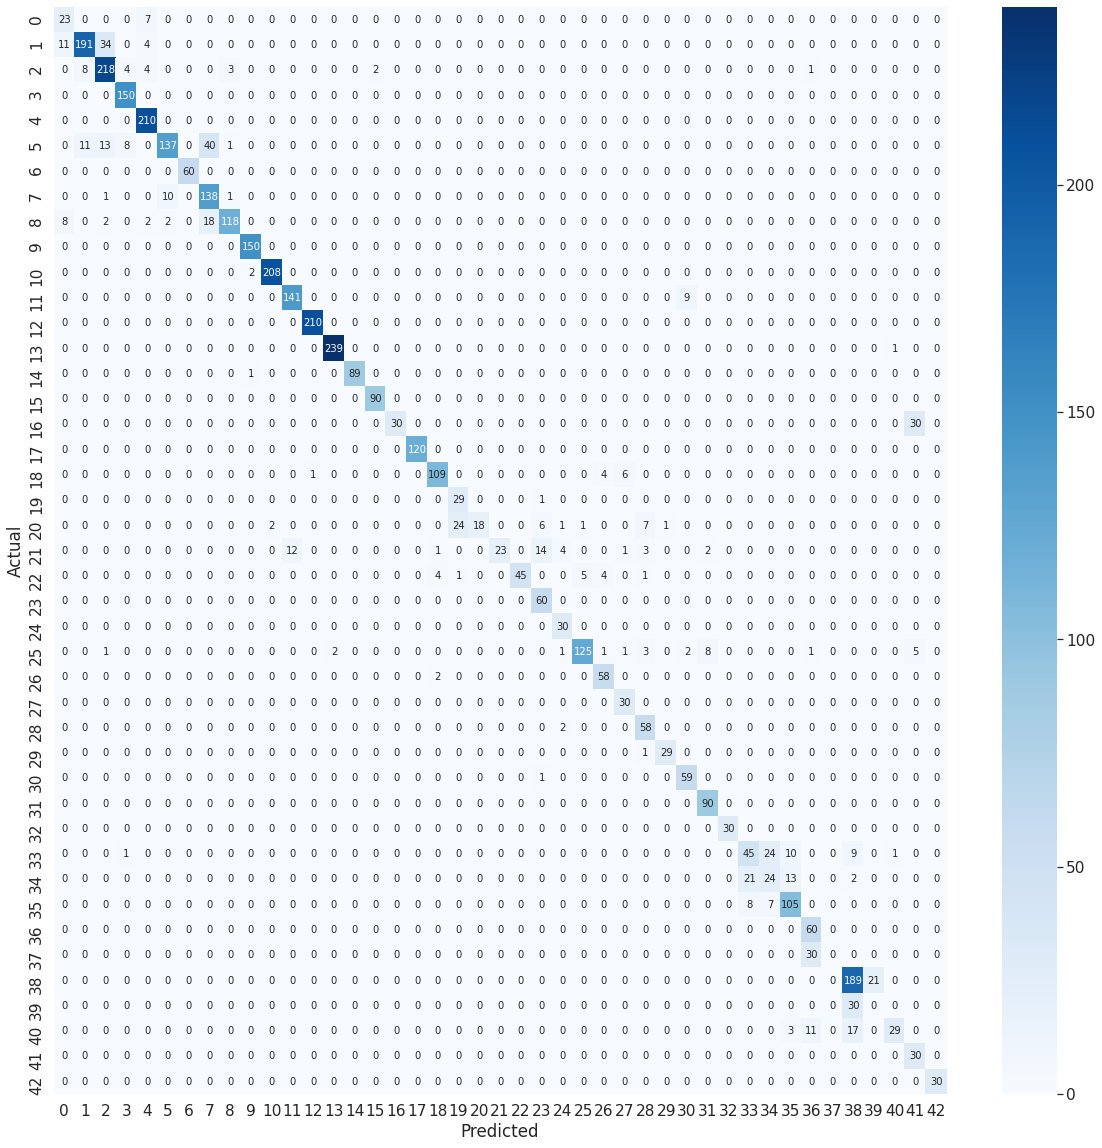

In [235]:
from sklearn.metrics import confusion_matrix

vi = valid['features']/255.0

y_prob = model_3.predict(vi) 
y_pred = y_prob.argmax(axis=-1)

data = confusion_matrix(valid['labels'], y_pred)
df_cm = pd.DataFrame(data)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (20,20))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues",fmt="d", annot=True,annot_kws={"size": 10},)# font size
plt.show()

In [236]:
label_names

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


In [237]:
def eval_visual_model(models, batch_sizes, epoch, draw_plot = False,early_stopping = False):
    for model in models:

      eses = []
      if early_stopping:
        es1 = EarlyStopping(monitor='accuracy', verbose=1,mode = 'max', patience=5)
        es2 = EarlyStopping(monitor='val_loss', verbose=1, patience=5,mode = 'min' ) #when validation loss starts to increase means we start overfitting so it stops after 5 epochs
        eses = [es1,es2]

      Model = model.fit(train_gen, 
                    class_weight = class_weights_dict,
                    epochs=epoch, 
                    verbose = 1,
                    callbacks = eses,
                    validation_data = test_gen,
                    steps_per_epoch=train_images.shape[0]//batch_sizes,
                    validation_steps= test_images.shape[0] // batch_sizes)

      print('\n\nResult on Test Set:')
      t = model.evaluate(test_images, test_labels)
      print('\nResult on Validation Set:')
      v = model.evaluate(valid_images, valid_labels)

      if draw_plot :
        plt.plot(Model.history['loss'])
        plt.plot(Model.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['loss', 'val_loss'], loc='lower right')
        plt.show()
      return Model


###Trying grayscale images instead of color:<h2>




In [56]:
train_images = train['features'].reshape(-1,3,32,32).astype('float32')
train_labels = train['labels']

valid_images = valid['features'].reshape(-1,3,32,32).astype('float32')
valid_labels = valid['labels']

test_images = test['features'].reshape(-1,3,32,32).astype('float32')
test_labels = test['labels']

In [57]:
train_labels = to_categorical(train_labels, num_classes=43)
valid_labels = to_categorical(valid_labels, num_classes=43)
test_labels = to_categorical(test_labels, num_classes=43)

In [11]:
type(train_images)

numpy.ndarray

In [12]:
import cv2

In [13]:
def to_gray(image):
  k = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  return k

In [58]:
gs_train = np.array([to_gray(i) for i in train['features']]).reshape(-1,32,32,1)
gs_test = np.array([to_gray(i) for i in test['features'] ]).reshape(-1,32,32,1)
gs_valid = np.array([to_gray(i) for i in valid['features'] ]).reshape(-1,32,32,1)

In [59]:
gs_train , train_labels = shuffle(gs_train, train_labels)
gs_test , test_labels = shuffle(gs_test , test_labels)

####Histogram Equalization

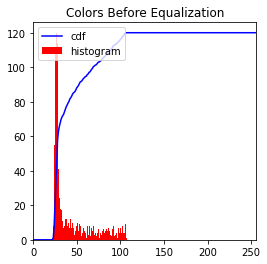

In [18]:
import cv2

img = to_gray(train['features'][1])
# plt.imshow(img, cmap = 'gray')
hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()
plt.figure(figsize = (4,4))
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'red')
plt.xlim([0,256])
plt.title('Colors Before Equalization')
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

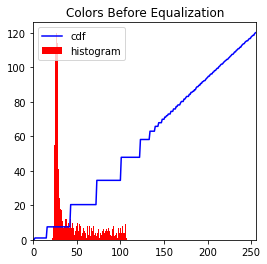

In [19]:
equ = cv2.equalizeHist(img)
hist,bins = np.histogram(equ.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()
plt.figure(figsize = (4,4))
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'red')
plt.xlim([0,256])
plt.title('Colors Before Equalization')
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

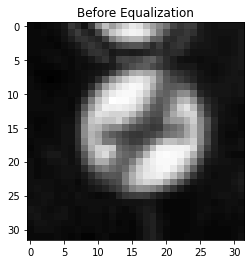

In [20]:
plt.title('Before Equalization')
plt.imshow(img,cmap = 'gray')

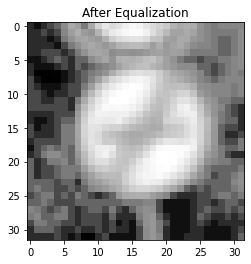

In [21]:
plt.title('After Equalization')
plt.imshow(equ,cmap = 'gray')

Equalizing all images:

In [60]:
gs_train = np.array([ cv2.equalizeHist(img) for img in gs_train] ).reshape(-1,32,32,1)
gs_test = np.array([ cv2.equalizeHist(img) for img in gs_test] ).reshape(-1,32,32,1)
gs_valid = np.array([ cv2.equalizeHist(img) for img in gs_valid] ).reshape(-1,32,32,1)


In [23]:
len(gs_train)

34799

In [61]:
gs_train = gs_train/ 255.0
gs_test = gs_test/255.0
gs_valid = gs_valid/255.0

In [62]:
gs_train[0][0][0]

array([0.25882353])

Testing the best model on gray scale images:

In [63]:
def eval_visual_model_gs(models, batch_sizes, epoch, draw_plot = False,early_stopping = False):
  train_gen = datagen.flow(gs_train,
                             y=train_labels,
                            batch_size = batch_sizes)

  test_gen = datagen.flow(gs_test,
                              y=test_labels,
                              batch_size = batch_sizes)
  for model in models:

    eses = []
    if early_stopping:
      es1 = EarlyStopping(monitor='accuracy', verbose=1,mode = 'max', patience=5)
      es2 = EarlyStopping(monitor='val_loss', verbose=1, patience=5,mode = 'min' ) #when validation loss starts to increase means we start overfitting so it stops after 5 epochs
      eses = [es1,es2]

    Model = model.fit(train_gen, 
                  class_weight = class_weights_dict,
                  epochs=epoch, 
                  verbose = 1,
                  callbacks = eses,
                  validation_data = test_gen,
                  steps_per_epoch=gs_train.shape[0]//batch_sizes,
                  validation_steps= gs_test.shape[0] // batch_sizes)

    print('\n\nResult on Test Set in Gray Scale:')
    t = model.evaluate(gs_test, test_labels)
    print('\nResult on Validation Setin Gray Scale:')
    v = model.evaluate(gs_valid, valid_labels)

    if draw_plot :
      plt.plot(Model.history['loss'])
      plt.plot(Model.history['val_loss'])
      plt.title('Model Loss')
      plt.ylabel('Loss')
      plt.xlabel('Epoch')
      plt.legend(['loss', 'val_loss'], loc='upper right')
      plt.show()
    return Model


In [64]:
model_gr = Sequential()

model_gr.add(Conv2D(32, kernel_size=15, padding='same', activation='relu', input_shape=(32, 32, 1)))
model_gr.add(MaxPool2D(pool_size=2))
model_gr.add(Dropout(0.1))

model_gr.add(Conv2D(64, kernel_size=12, padding='same', activation='relu', input_shape=(32, 32, 1)))
model_gr.add(Dense(64, activation='relu'))
model_gr.add(BatchNormalization() )
model_gr.add(Dropout(0.2))

model_gr.add(Conv2D(81, kernel_size=9, padding='same', activation='relu', input_shape=(32, 32, 1)))
model_gr.add(AveragePooling2D( pool_size=2, strides=2, padding="same"))
model_gr.add(BatchNormalization() )
model_gr.add(Dropout(0.1))


model_gr.add(Conv2D(100, kernel_size=6, padding='same', activation='relu', input_shape=(32, 32, 1)))
model_gr.add(MaxPool2D(pool_size=2))

model_gr.add(Conv2D(80, kernel_size=6, padding='same', activation='relu', input_shape=(32, 32, 1)))
model_gr.add(BatchNormalization( ) )

model_gr.add(Conv2D(64, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 1)))
model_gr.add(MaxPool2D(pool_size=2))


model_gr.add(Flatten())

model_gr.add(Dense(64, activation='relu'))
model_gr.add(Dropout(0.1))

model_gr.add(Dense(50, activation='relu'))



model_gr.add(Dense(43, activation='softmax'))
model_gr.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/300
695/695 [==============================] - 17s 24ms/step - loss: 3.5829 - accuracy: 0.0354 - val_loss: 3.6495 - val_accuracy: 0.0460
Epoch 2/300
695/695 [==============================] - 16s 24ms/step - loss: 3.0868 - accuracy: 0.0974 - val_loss: 2.8231 - val_accuracy: 0.1470
Epoch 3/300
695/695 [==============================] - 16s 24ms/step - loss: 2.3692 - accuracy: 0.2467 - val_loss: 2.1064 - val_accuracy: 0.3193
Epoch 4/300
695/695 [==============================] - 17s 24ms/step - loss: 1.7921 - accuracy: 0.3969 - val_loss: 2.3801 - val_accuracy: 0.3213
Epoch 5/300
695/695 [==============================] - 16s 24ms/step - loss: 1.3660 - accuracy: 0.5004 - val_loss: 1.4868 - val_accuracy: 0.4948
Epoch 6/300
695/695 [==============================] - 17s 24ms/step - loss: 1.0946 - accuracy: 0.5908 - val_loss: 1.3926 - val_accuracy: 0.5808
Epoch 7/300
695/695 [==============================] - 17s 24ms/step - loss: 0.9504 - accuracy: 0.6434 - val_loss: 1.1386 - val_ac

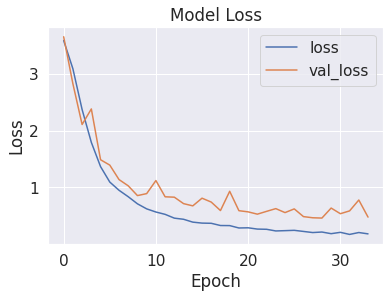

In [65]:
eval_visual_model_gs([model_gr],50,300,draw_plot = True , early_stopping=True)

The result was better than all last networks.

There is a guess. Maybe because most color are red and blue in trrafic signs, it can help to remove green part and learn the new data.

<h2> Trying Red And Blue Images:

In [29]:
train_images = train['features']/255.0
train_labels = train['labels']

valid_images = valid['features']/255.0
valid_labels = valid['labels']

test_images = test['features']/255.0
test_labels = test['labels']

(34799, 32, 32, 3)


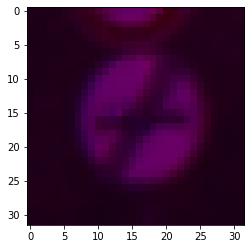

In [30]:
print(train_images.shape)
#By assuming color order is red green blue

#Remove green part from all:
for size in range(len(train_images)) :
  for w in range(32):
    for h in range(32):
      train_images[size][w][h][1] = 0
for size in range(len(test_images)) :
  for w in range(32):
    for h in range(32):
      test_images[size][w][h][1] = 0
for size in range(len(valid_images)) :
  for w in range(32):
    for h in range(32):
      valid_images[size][w][h][1] = 0

rb_images = train_images[5][:][:][:]

img = rb_images
plt.imshow(img )

plt.show()
  

In [31]:
from sklearn.utils import shuffle

train_images , train_labels = shuffle(train_images, train_labels)
valid_images , valid_labels = shuffle(valid_images , valid_labels)

test_images , test_labels = shuffle(test_images , test_labels)


In [32]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(list( train['labels']))
y = le.transform(list( train['labels']))

class_weights = compute_class_weight('balanced', np.unique(y),y )

class_weights_dict = dict(zip(le.transform(list(le.classes_)), class_weights))


In [33]:
train_labels = to_categorical(train_labels, num_classes=43)
valid_labels = to_categorical(valid_labels, num_classes=43)
test_labels = to_categorical(test_labels, num_classes=43)

In [34]:
def eval_visual_model_rb(models, batch_sizes, epoch, draw_plot = False,early_stopping = False):

    train_gen = datagen.flow(train_images,
                                y=train_labels,
                                batch_size = batch_sizes)

    valid_gen = datagen.flow(valid_images,
                                y=valid_labels,
                                batch_size = batch_sizes)

    for model in models:

      eses = []
      if early_stopping:
        es1 = EarlyStopping(monitor='accuracy', verbose=1,mode = 'max', patience=5)
        es2 = EarlyStopping(monitor='val_loss', verbose=1, patience=5,mode = 'min' ) #when validation loss starts to increase means we start overfitting so it stops after 5 epochs
        eses = [es1,es2]

      Model = model.fit(train_gen, 
                    shuffle=True,
                    class_weight = class_weights_dict,
                    epochs=epoch, 
                    verbose = 1,
                    callbacks = eses,
                    validation_data = valid_gen,
                    steps_per_epoch=train_images.shape[0]//batch_sizes,
                    validation_steps= valid_images.shape[0] // batch_sizes)

      print('\n\nResult on Test Set:')
      t = model.evaluate(test_images, test_labels)
      print('\nResult on Validation Set:')
      v = model.evaluate(valid_images, valid_labels)

      if draw_plot :
        plt.plot(Model.history['loss'])
        plt.plot(Model.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['loss', 'val_loss'], loc='upper right')
        plt.show()
      return Model


In [35]:
model_rb = Sequential()

model_rb.add(Conv2D(32, kernel_size=12, padding='same', activation='relu', input_shape=(32, 32, 3)))
model_rb.add(MaxPool2D(pool_size=2))

model_rb.add(Dropout(0.2))

model_rb.add(Conv2D(64, kernel_size=9, padding='same', activation='relu', input_shape=(32, 32, 3)))
model_rb.add(Dense(16, activation='relu'))
model_rb.add(BatchNormalization() )

model_rb.add(Dropout(0.1))


model_rb.add(Conv2D(128, kernel_size=6, padding='same', activation='relu', input_shape=(32, 32, 3)))
model_rb.add(AveragePooling2D( pool_size=2, strides=2, padding="same"))
model_rb.add(BatchNormalization() )

model_rb.add(Dropout(0.2))


model_rb.add(Conv2D(180, kernel_size=9, padding='same', activation='relu', input_shape=(32, 32, 3)))
model_rb.add(MaxPool2D(pool_size=2))
model_rb.add(BatchNormalization( ) )

model_rb.add(Dropout(0.4))

model_rb.add(Conv2D(200, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)))
model_rb.add(MaxPool2D(pool_size=2))
model_rb.add(BatchNormalization( ) )

model_rb.add(Dropout(0.3))

model_rb.add(Flatten())

model_rb.add(Dense(128, activation='relu'))
model_rb.add(BatchNormalization( ) )
model_rb.add(Dropout(0.4))
model_rb.add(Dense(20, activation='relu'))

model_rb.add(Dense(43, activation='softmax'))
model_rb.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/500
289/289 [==============================] - 21s 73ms/step - loss: 3.5348 - accuracy: 0.0540 - val_loss: 3.3512 - val_accuracy: 0.0588
Epoch 2/500
289/289 [==============================] - 21s 73ms/step - loss: 2.8022 - accuracy: 0.1291 - val_loss: 2.7969 - val_accuracy: 0.1481
Epoch 3/500
289/289 [==============================] - 21s 73ms/step - loss: 2.1191 - accuracy: 0.3000 - val_loss: 1.9285 - val_accuracy: 0.3757
Epoch 4/500
289/289 [==============================] - 22s 75ms/step - loss: 1.5136 - accuracy: 0.4688 - val_loss: 1.7831 - val_accuracy: 0.4174
Epoch 5/500
289/289 [==============================] - 21s 72ms/step - loss: 1.1416 - accuracy: 0.5711 - val_loss: 1.1613 - val_accuracy: 0.5889
Epoch 6/500
289/289 [==============================] - 21s 72ms/step - loss: 0.8959 - accuracy: 0.6448 - val_loss: 1.2620 - val_accuracy: 0.5764
Epoch 7/500
289/289 [==============================] - 21s 73ms/step - loss: 0.7295 - accuracy: 0.6990 - val_loss: 1.0856 - val_ac

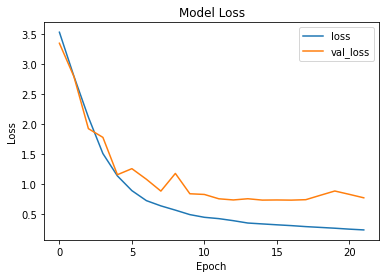

In [36]:
eval_visual_model_rb([model_rb],batch_sizes =  120, epoch = 500,draw_plot=True,early_stopping=True)

In [37]:
model_rb2 = Sequential()

model_rb2.add(Conv2D(32, kernel_size=12, padding='same', activation='relu', input_shape=(32, 32, 3)))
model_rb2.add(MaxPool2D(pool_size=2))

model_rb2.add(Dropout(0.2))

model_rb2.add(Conv2D(64, kernel_size=9, padding='same', activation='relu', input_shape=(32, 32, 3)))
model_rb2.add(Dense(16, activation='relu'))
model_rb2.add(BatchNormalization() )

model_rb2.add(Dropout(0.1))


model_rb2.add(Conv2D(128, kernel_size=6, padding='same', activation='relu', input_shape=(32, 32, 3)))
model_rb2.add(AveragePooling2D( pool_size=2, strides=2, padding="same"))
model_rb2.add(BatchNormalization() )

model_rb2.add(Dropout(0.2))


model_rb2.add(Conv2D(180, kernel_size=9, padding='same', activation='relu', input_shape=(32, 32, 3)))
model_rb2.add(MaxPool2D(pool_size=2))
model_rb2.add(BatchNormalization( ) )

model_rb2.add(Dropout(0.4))

model_rb2.add(Conv2D(64, kernel_size=6, padding='same', activation='relu', input_shape=(32, 32, 3)))
model_rb2.add(Dense(128, activation='relu'))
model_rb2.add(BatchNormalization( ) )

model_rb2.add(Dropout(0.5))


model_rb2.add(Conv2D(200, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)))
model_rb2.add(MaxPool2D(pool_size=2))
model_rb2.add(BatchNormalization( ) )

model_rb2.add(Dropout(0.3))

model_rb2.add(Flatten())

model_rb2.add(Dense(128, activation='relu'))
model_rb2.add(BatchNormalization( ) )
model_rb2.add(Dropout(0.4))
model_rb2.add(Dense(20, activation='relu'))

model_rb2.add(Dense(43, activation='softmax'))
model_rb2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/500
231/231 [==============================] - 21s 90ms/step - loss: 3.8065 - accuracy: 0.0276 - val_loss: 3.8290 - val_accuracy: 0.0322
Epoch 2/500
231/231 [==============================] - 21s 89ms/step - loss: 3.5813 - accuracy: 0.0447 - val_loss: 3.7560 - val_accuracy: 0.0418
Epoch 3/500
231/231 [==============================] - 20s 87ms/step - loss: 3.1713 - accuracy: 0.0703 - val_loss: 3.2743 - val_accuracy: 0.0589
Epoch 4/500
231/231 [==============================] - 20s 88ms/step - loss: 2.7110 - accuracy: 0.1182 - val_loss: 2.9996 - val_accuracy: 0.0989
Epoch 5/500
231/231 [==============================] - 20s 88ms/step - loss: 2.2387 - accuracy: 0.2229 - val_loss: 2.3871 - val_accuracy: 0.2368
Epoch 6/500
231/231 [==============================] - 20s 88ms/step - loss: 1.7876 - accuracy: 0.3594 - val_loss: 2.0588 - val_accuracy: 0.3239
Epoch 7/500
231/231 [==============================] - 20s 88ms/step - loss: 1.4530 - accuracy: 0.4675 - val_loss: 1.6980 - val_ac

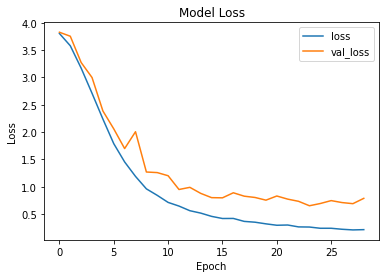

In [38]:
eval_visual_model_rb([model_rb2],batch_sizes =  150, epoch = 500,draw_plot=True,early_stopping=True)


Did not changed so much in compare of colorful images.

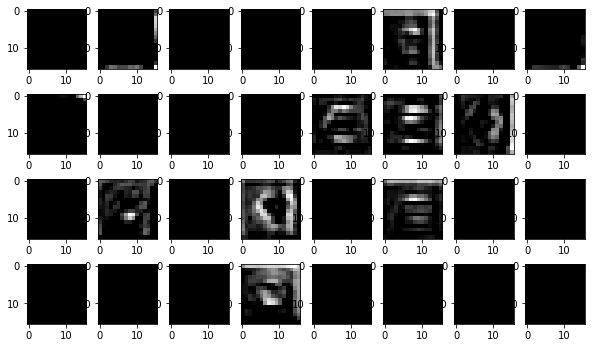

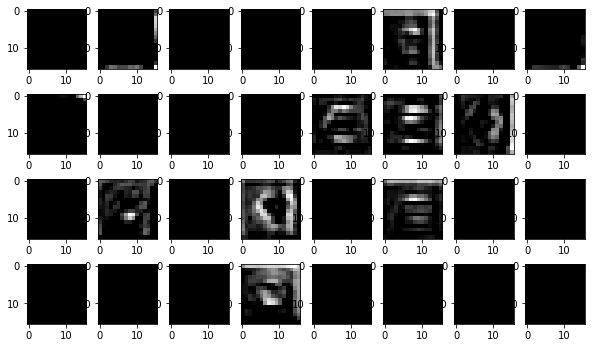

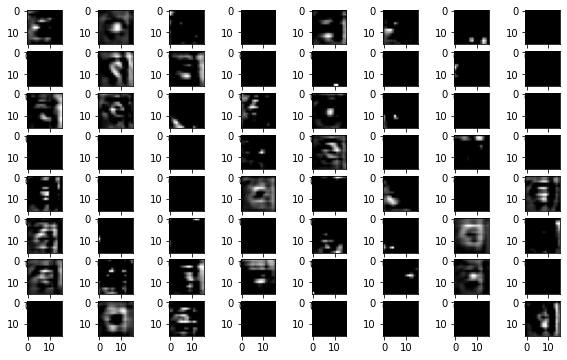

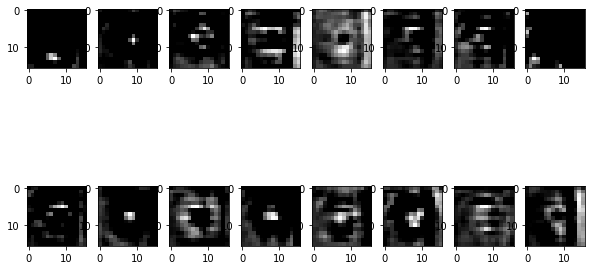

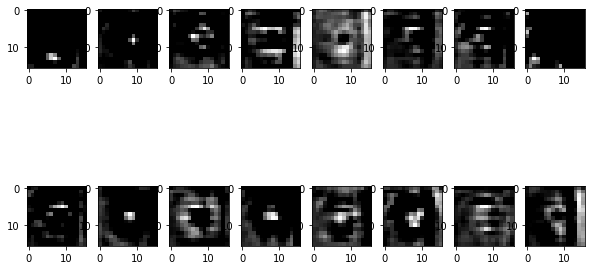

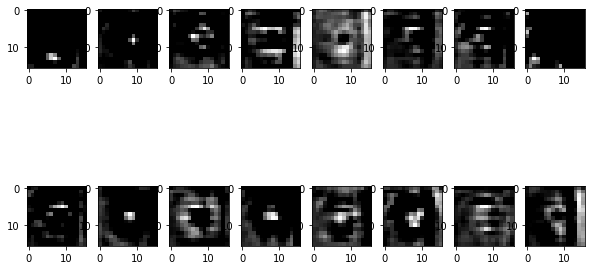

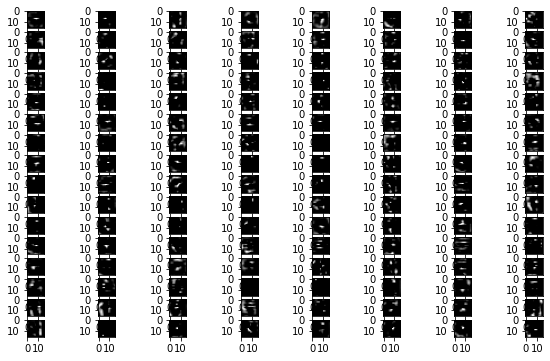

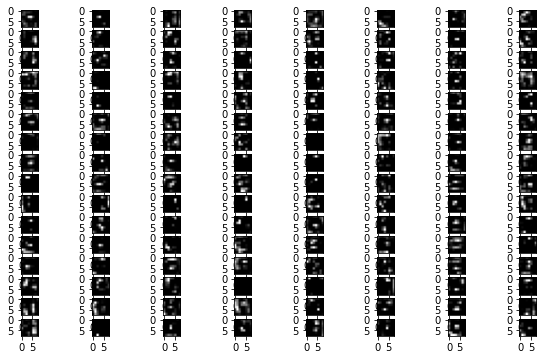

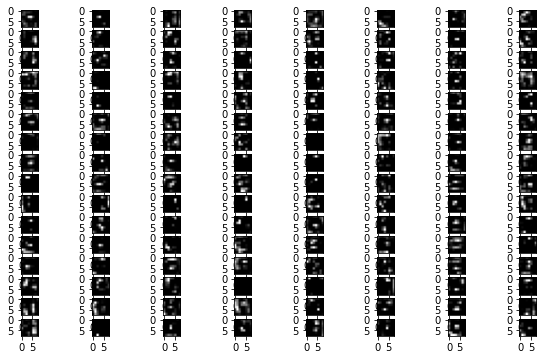

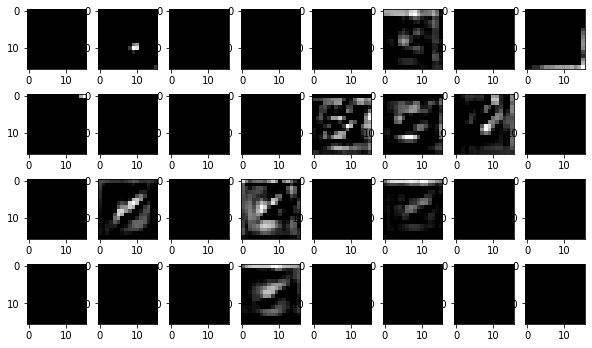

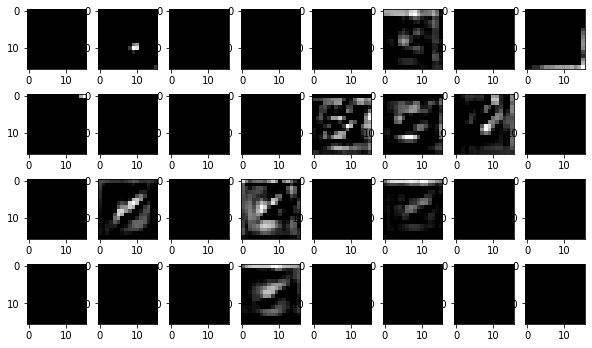

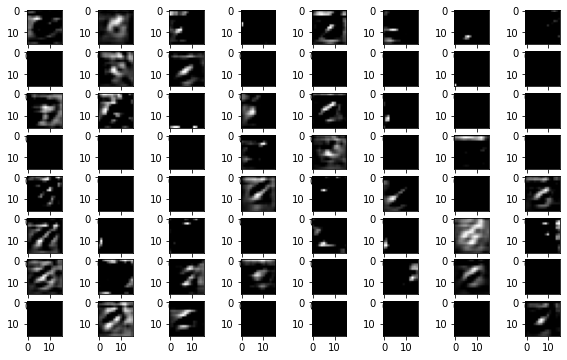

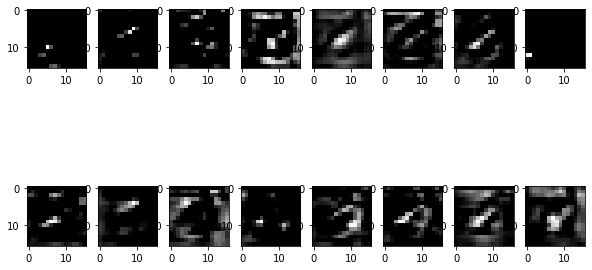

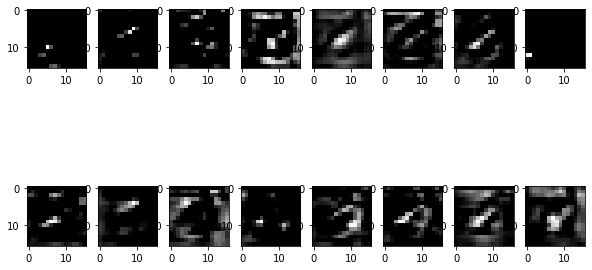

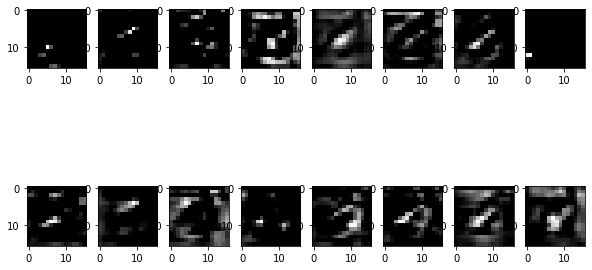

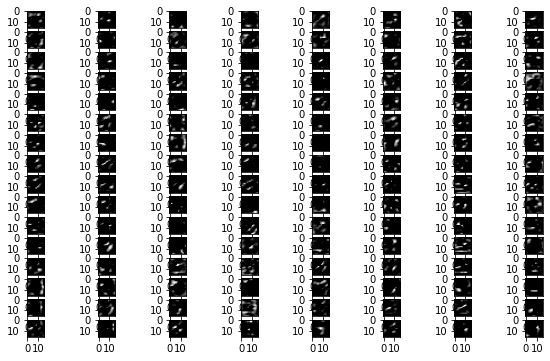

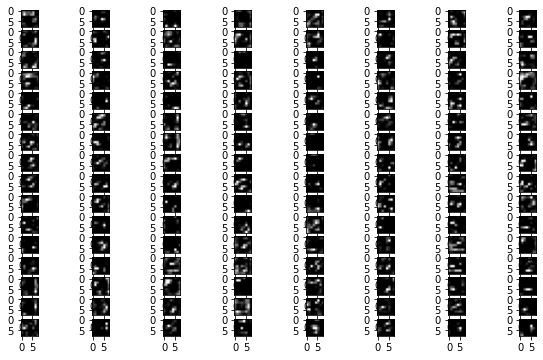

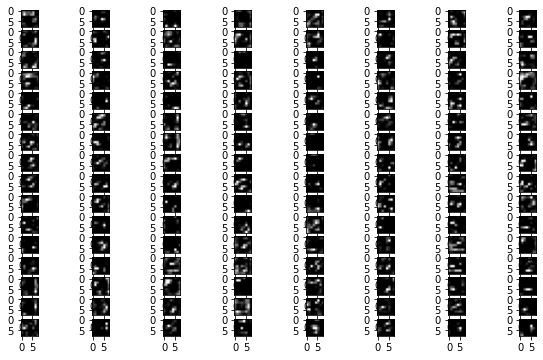

In [39]:
import tensorflow as tf

images = [train_images[0],train_images[720]]
for i in images:
  for n_layer in range(1,10):
    model_layer = tf.keras.Model(inputs=model_rb2.inputs, outputs=model_rb2.layers[n_layer].output)
    feature_maps = model_layer.predict(i.reshape(1,32,32,3))

    n_row = int(feature_maps.shape[-1]/8)
    n_col = 8
    plt.figure(figsize=(10,6))
    ix = 1
    for _ in range(n_row):
      for _ in range(n_col):
        ax = plt.subplot(n_row, n_col, ix)
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
    plt.show()

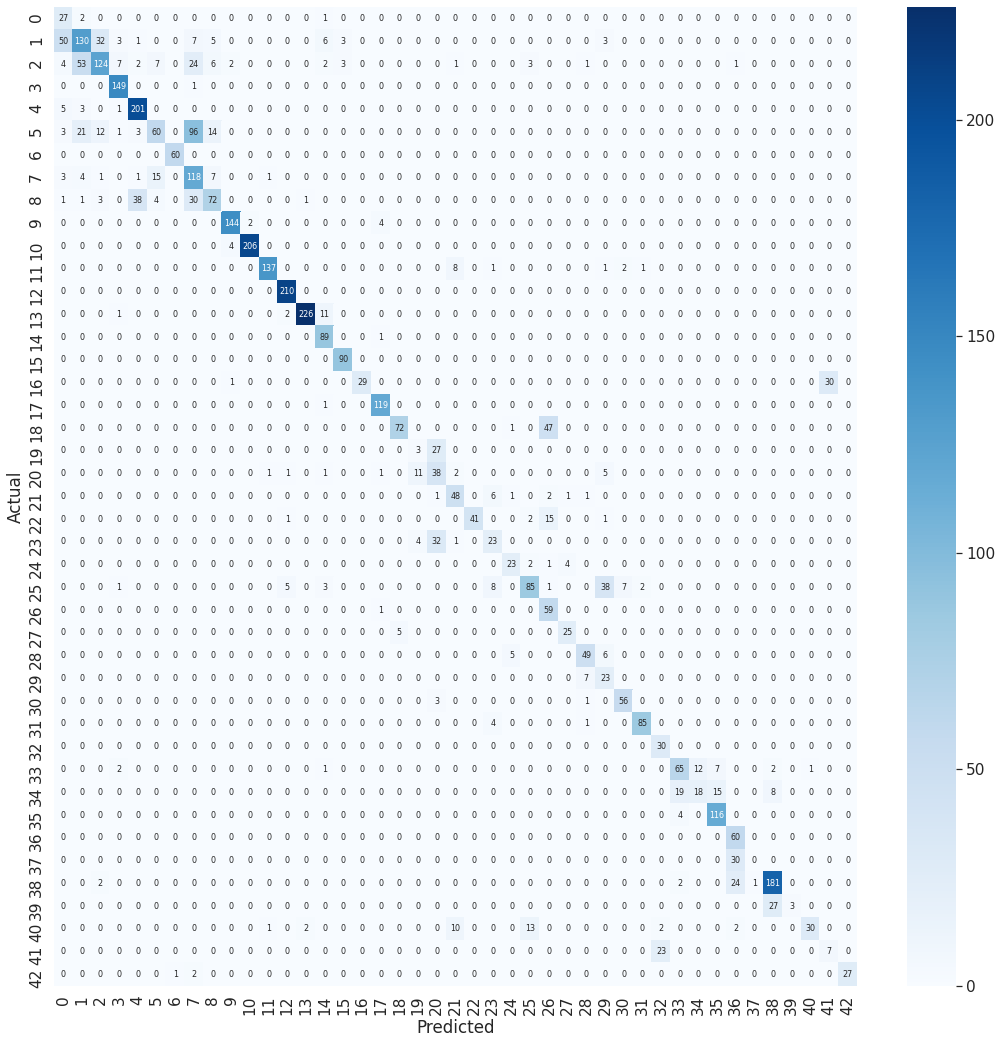

In [41]:
from sklearn.metrics import confusion_matrix
vi = valid['features']/255.0
y_prob = model_rb2.predict(vi) 
y_pred = y_prob.argmax(axis=-1)

data = confusion_matrix(valid['labels'], y_pred)
df_cm = pd.DataFrame(data)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (18,18))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues",fmt="d", annot=True,annot_kws={"size": 8},)# font size
plt.show()

Save the best result 

In [67]:
import joblib
#model_gr was best up to here
joblib.dump(value=model_gr.weights, filename=f"weights_pr2-1.pkl")

['weights_pr2-1.pkl']